In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle

from scipy.interpolate import SmoothBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Step 1: Generate Synthetic Data
n_samples = 10000
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=2.5, random_state=42)


In [2]:
with open('data/reset_splines.pkl', 'rb') as f:
    reset_splines = pickle.load(f)
with open('data/set_splines.pkl', 'rb') as f:
    set_splines = pickle.load(f)

In [3]:

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [6]:

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input layer (2 features) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 2)   # Hidden layer (16 neurons) to output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = self.fc2(x)               # No activation for output layer
        return x


In [7]:
class HardwareAwareOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, set_splines=None, reset_splines = None):
        defaults = dict(lr=lr)
        self.set_splines = set_splines
        self.reset_splines = reset_splines
        super(HardwareAwareOptimizer, self).__init__(params, defaults)

    def step(self):
        def map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance):
            # Linear interpolation from weight to conductance
            normalized_weights = (weight - min_weight) / (max_weight - min_weight)
            mapped_conductance = min_conductance + normalized_weights * (max_conductance - min_conductance)
            mapped_conductance = torch.clamp(mapped_conductance, min_conductance, max_conductance)
            return mapped_conductance
        
        def new_conductance(G0, grad):
            # Apply the splines based on gradient
            positive_mask = torch.le(grad, 0)  # Check for grad >= 0
            G_new_positive = G0 * (self.set_splines['10 us'].ev(G0, 1.6))
            G_new_negative = G0 * (self.reset_splines['10 us'].ev(G0, -1.8))
            
            # Combine both positive and negative cases
            G_new = torch.where(positive_mask, G_new_positive, G_new_negative)
            return G_new

        def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
            # Reverse mapping from conductance to weight

            normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
            mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
            mapped_weight = torch.clamp(mapped_weight, min_weight, max_weight)
            return mapped_weight

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                min_weight, max_weight = -1.5, 1.5
                min_conductance, max_conductance = 5e-7, 6e-6
                
                # Get the current weights and gradients
                weight, grad = p.data, p.grad.data

                # 1. Map weights to conductance values
                G0 = map_weights_to_conductance(
                    weight=weight,
                    min_weight=min_weight,
                    max_weight=max_weight,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance
                )

                # 2. Modify conductance using spline function based on the gradient
                G_new = new_conductance(G0=G0, grad=grad)

                # 3. Map the new conductance values back to weights
                new_weight = map_conductance_to_weights(
                    conductance=G_new,
                    min_conductance=min_conductance,
                    max_conductance=max_conductance,
                    min_weight=min_weight,
                    max_weight=max_weight
                )
                
                # Update the weights in the optimizer
                p.data.copy_(new_weight)  # In-place update of the weights


In [10]:
def map_weights_to_conductance(weight, min_weight, max_weight, min_conductance, max_conductance):
            # Element-wise comparison for tensors
            weight = torch.clamp(weight, min=min_weight, max=max_weight)  # Clamp the weight between min and max weight
            
            normalized_weights = (weight - min_weight) / (max_weight - min_weight)
            
            # Map normalized values to [min_conductance, max_conductance] range
            mapped_conductance = min_conductance + normalized_weights * (max_conductance - min_conductance)
            mapped_conductance = torch.clamp(mapped_conductance, min_conductance, max_conductance)
            
            return mapped_conductance
def new_conductance(G0, grad):
            # Create a mask where grad >= 0
            positive_mask = torch.ge(grad, 0)  # Element-wise comparison
            
            # For grad >= 0, use the set_splines function
            G_new_positive = G0 * (set_splines['10 ns'].ev(G0, 1.6)  )
            
            # For grad < 0, use the reset_splines function
            G_new_negative = G0 * (reset_splines['10 ns'].ev(G0, -1.8) )
            # Combine the two based on the mask
            G_new = torch.where(positive_mask, G_new_positive, G_new_negative)
            
            return G_new


        

        # Mapping conductance back to weights
def map_conductance_to_weights(conductance, min_conductance, max_conductance, min_weight, max_weight):
            normalized_conductance = (conductance - min_conductance) / (max_conductance - min_conductance)
            mapped_weight = min_weight + normalized_conductance * (max_weight - min_weight)
            mapped_weight = torch.clamp(mapped_weight, min_weight, max_weight)
            return torch.tensor(mapped_weight)

min_weight, max_weight = -1.5, 1.5
min_conductance, max_conductance = 5e-7, 6e-6

for weight in torch.linspace(-1.5, 1.5, 16):
        
    weight, grad = torch.tensor(weight), torch.tensor(0.3)
    G0 = map_weights_to_conductance(
                        weight=weight,
                        min_weight=min_weight,
                        max_weight=max_weight,
                        min_conductance=min_conductance,
                        max_conductance=max_conductance
        )
                    
                    # Update conductance based on gradient
    G_new = new_conductance(G0=G0, grad=grad)
    new_weight = map_conductance_to_weights(
                        conductance=G_new,
                        min_conductance=min_conductance,
                        max_conductance=max_conductance,
                        min_weight=min_weight,
                        max_weight=max_weight
    )
    print(f"Weight = {weight}, new weight = {new_weight}")

Weight = -1.5, new weight = -1.5
Weight = -1.2999999523162842, new weight = -1.2712894564141601
Weight = -1.100000023841858, new weight = -1.0645920834813676
Weight = -0.8999999761581421, new weight = -0.897506459364032
Weight = -0.699999988079071, new weight = -0.7703645860213013
Weight = -0.5, new weight = -0.6728745691967124
Weight = -0.2999999523162842, new weight = -0.5891900937297265
Weight = -0.10000002384185791, new weight = -0.5021302605317453
Weight = 0.10000002384185791, new weight = -0.39655056727915516
Weight = 0.2999999523162842, new weight = -0.2618650099729678
Weight = 0.5, new weight = -0.09371864875924918
Weight = 0.699999988079071, new weight = 0.10518752338657444
Weight = 0.8999999761581421, new weight = 0.32512205342592826
Weight = 1.100000023841858, new weight = 0.5501962193236705
Weight = 1.2999999523162842, new weight = 0.7600893938119535
Weight = 1.5, new weight = 0.9326162435330265


C:\Users\adith\AppData\Local\Temp\ipykernel_27744\2754681267.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight, grad = torch.tensor(weight), torch.tensor(0.3)
C:\Users\adith\AppData\Local\Temp\ipykernel_27744\2754681267.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mapped_weight)


In [11]:

# Create the model
model = MLP()
# Step 3: Train the Model
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = HardwareAwareOptimizer(model.parameters(), lr=0.01, set_splines=set_splines, reset_splines=reset_splines)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/1000], Loss: 0.6931
Epoch [20/1000], Loss: 0.6931
Epoch [30/1000], Loss: 0.6931
Epoch [40/1000], Loss: 0.6931
Epoch [50/1000], Loss: 0.6931
Epoch [60/1000], Loss: 0.6931
Epoch [70/1000], Loss: 0.6931
Epoch [80/1000], Loss: 0.6931
Epoch [90/1000], Loss: 0.6931
Epoch [100/1000], Loss: 0.6931
Epoch [110/1000], Loss: 0.6931
Epoch [120/1000], Loss: 0.6931
Epoch [130/1000], Loss: 0.6931
Epoch [140/1000], Loss: 0.6931
Epoch [150/1000], Loss: 0.6931
Epoch [160/1000], Loss: 0.6931
Epoch [170/1000], Loss: 0.6931
Epoch [180/1000], Loss: 0.6931
Epoch [190/1000], Loss: 0.6931
Epoch [200/1000], Loss: 0.6931
Epoch [210/1000], Loss: 0.6931
Epoch [220/1000], Loss: 0.6931
Epoch [230/1000], Loss: 0.6931
Epoch [240/1000], Loss: 0.6931
Epoch [250/1000], Loss: 0.6931
Epoch [260/1000], Loss: 0.6931
Epoch [270/1000], Loss: 0.6931
Epoch [280/1000], Loss: 0.6931
Epoch [290/1000], Loss: 0.6931
Epoch [300/1000], Loss: 0.6931
Epoch [310/1000], Loss: 0.6931
Epoch [320/1000], Loss: 0.6931
Epoch [330/1000],

Accuracy: 96.95%
Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Confusion Matrix:
[[1885  104]
 [  18 1993]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1989
           1       0.95      0.99      0.97      2011

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



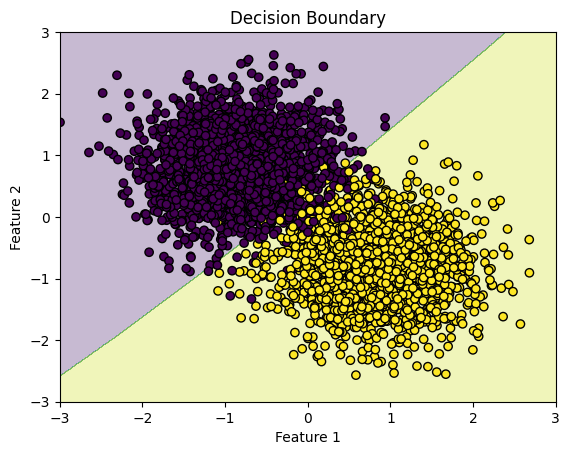

In [32]:

# Step 4: Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_tensor, predicted)
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    cm = confusion_matrix(y_test_tensor, predicted)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(y_test_tensor, predicted))

# Plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 1000), np.linspace(-3, 3, 1000))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = model(grid)
    _, Z = torch.max(Z.data, 1)
Z = Z.numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
